In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import pandas as pd
DIR = "/content/drive/MyDrive/archive.zip.zip (Unzipped Files)/archive.zip (Unzipped Files)/dataset/"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Building The Model:





In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                         

## Configuring the network for training

---




In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory( # create Dataset objects in batches of 32 images
    DIR + "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    DIR + "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    DIR + "test",
    image_size=(180, 180),
    batch_size=32)

Found 840 files belonging to 2 classes.
Found 94 files belonging to 2 classes.
Found 94 files belonging to 2 classes.


## Displaying the shapes of the data and labels yielded by the Dataset


In [ ]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


## Fitting the model using a Dataset - First Model


In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
27/27 [==============================] - 70s 2s/step - loss: 0.7770 - accuracy: 0.4821 - val_loss: 0.6940 - val_accuracy: 0.5000
Epoch 2/30
27/27 [==============================] - 5s 167ms/step - loss: 0.6949 - accuracy: 0.5155 - val_loss: 0.7732 - val_accuracy: 0.5000
Epoch 3/30
27/27 [==============================] - 4s 134ms/step - loss: 0.6975 - accuracy: 0.5167 - val_loss: 0.6901 - val_accuracy: 0.6064
Epoch 4/30
27/27 [==============================] - 4s 132ms/step - loss: 0.6964 - accuracy: 0.5643 - val_loss: 0.6703 - val_accuracy: 0.4894
Epoch 5/30
27/27 [==============================] - 4s 131ms/step - loss: 0.6983 - accuracy: 0.5345 - val_loss: 0.6836 - val_accuracy: 0.5957
Epoch 6/30
27/27 [==============================] - 4s 133ms/step - loss: 0.6914 - accuracy: 0.5714 - val_loss: 0.6417 - val_accuracy: 0.5851
Epoch 7/30
27/27 [==============================] - 4s 131ms/step - loss: 0.6856 - accuracy: 0.5690 - val_loss: 0.6906 - val_accuracy: 0.5532
Epoch 8/

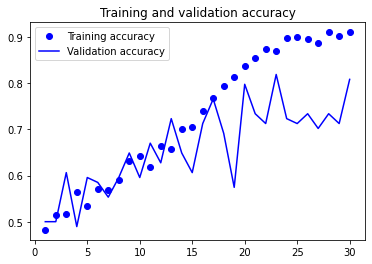

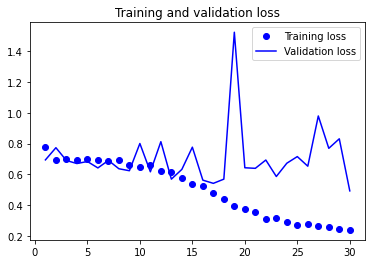

In [ ]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

###  Evaluating the model on the test set

In [ ]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

3/3 [==============================] - 13s 38ms/step - loss: 0.6046 - accuracy: 0.7447
Test accuracy: 0.745


# Using data augmentation - The Second Model



## Define a data augmentation stage to add to an image model

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

## Displaying some randomly augmented training images



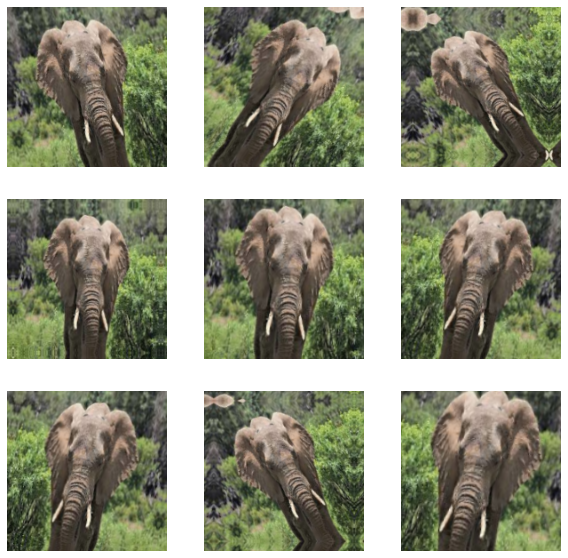

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1): 
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

##  Defining a new convnet that includes image augmentation and dropout


In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

## Training the regularized networks


In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/100
27/27 [==============================] - 6s 148ms/step - loss: 0.8185 - accuracy: 0.4821 - val_loss: 0.6928 - val_accuracy: 0.5000
Epoch 2/100
27/27 [==============================] - 4s 141ms/step - loss: 0.6946 - accuracy: 0.5036 - val_loss: 0.6922 - val_accuracy: 0.5000
Epoch 3/100
27/27 [==============================] - 4s 137ms/step - loss: 0.7019 - accuracy: 0.4893 - val_loss: 0.6913 - val_accuracy: 0.5000
Epoch 4/100
27/27 [==============================] - 4s 133ms/step - loss: 0.7271 - accuracy: 0.5238 - val_loss: 0.6935 - val_accuracy: 0.5106
Epoch 5/100
27/27 [==============================] - 4s 134ms/step - loss: 0.6905 - accuracy: 0.5476 - val_loss: 0.7793 - val_accuracy: 0.5000
Epoch 6/100
27/27 [==============================] - 4s 139ms/step - loss: 0.6983 - accuracy: 0.5452 - val_loss: 0.7075 - val_accuracy: 0.5000
Epoch 7/100
27/27 [==============================] - 4s 138ms/step - loss: 0.7029 - accuracy: 0.5452 - val_loss: 0.6789 - val_accuracy: 0.5851

## evaluating the the new model


In [ ]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")


3/3 [==============================] - 1s 30ms/step - loss: 0.5973 - accuracy: 0.7340
Test accuracy: 0.734


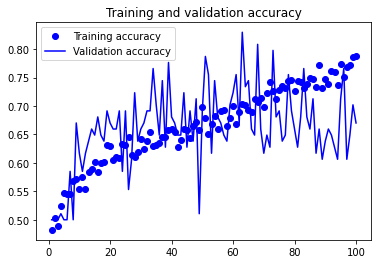

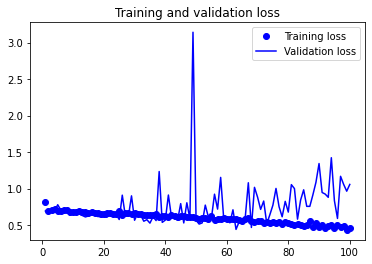

In [ ]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

#Leveraging a pretrained model- Third Model

## Instantiating the VGG16 convolutional base

In [ ]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

# Fast feature extraction without data augmentation


## Extracting the VGG16 features and corresponding labels




Defining and training the densely connected classifier

## Feature extraction together with data augmentation Instantiating and freezing the VGG16 convolutional base

In [ ]:

conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False


58900480/58889256 [==============================] - 1s 0us/step


## Adding a data augmentation stage and a classifier to the convolutional base

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
27/27 [==============================] - 99s 2s/step - loss: 87.5080 - accuracy: 0.5821 - val_loss: 34.9213 - val_accuracy: 0.7872
Epoch 2/50
27/27 [==============================] - 7s 240ms/step - loss: 52.5904 - accuracy: 0.6369 - val_loss: 39.2727 - val_accuracy: 0.7234
Epoch 3/50
27/27 [==============================] - 7s 247ms/step - loss: 34.8753 - accuracy: 0.6976 - val_loss: 15.5735 - val_accuracy: 0.8085
Epoch 4/50
27/27 [==============================] - 7s 238ms/step - loss: 32.9257 - accuracy: 0.6857 - val_loss: 60.0653 - val_accuracy: 0.6383
Epoch 5/50
27/27 [==============================] - 7s 238ms/step - loss: 29.9316 - accuracy: 0.7071 - val_loss: 24.1162 - val_accuracy: 0.7340
Epoch 6/50
27/27 [==============================] - 7s 241ms/step - loss: 24.7992 - accuracy: 0.7357 - val_loss: 29.1899 - val_accuracy: 0.7340
Epoch 7/50
27/27 [==============================] - 7s 242ms/step - loss: 24.1531 - accuracy: 0.7071 - val_loss: 44.4082 - val_accuracy: 0

## Evaluating the model on the test set

In [ ]:
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

3/3 [==============================] - 2s 182ms/step - loss: 0.7365 - accuracy: 0.8723
Test accuracy: 0.872


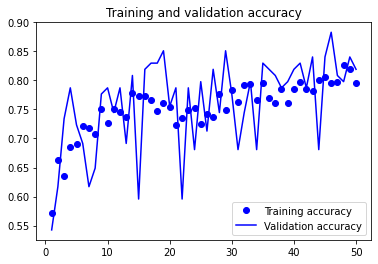

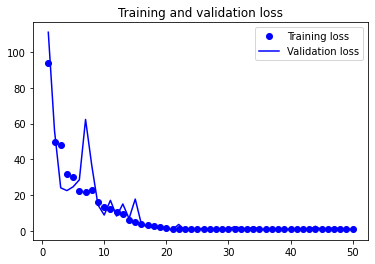

In [ ]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

# Fine-tuning a pretrained model - Last Model

In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

## Freezing all layers until the fourth from the last

In [ ]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

## Fine-tuning the model

In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
27/27 [==============================] - 14s 316ms/step - loss: 0.1198 - accuracy: 0.9440 - val_loss: 0.4935 - val_accuracy: 0.8617
Epoch 2/50
27/27 [==============================] - 9s 299ms/step - loss: 0.1265 - accuracy: 0.9405 - val_loss: 0.4583 - val_accuracy: 0.8511
Epoch 3/50
27/27 [==============================] - 9s 299ms/step - loss: 0.1091 - accuracy: 0.9488 - val_loss: 0.4329 - val_accuracy: 0.8723
Epoch 4/50
27/27 [==============================] - 9s 301ms/step - loss: 0.1309 - accuracy: 0.9393 - val_loss: 0.3727 - val_accuracy: 0.8723
Epoch 5/50
27/27 [==============================] - 9s 303ms/step - loss: 0.1321 - accuracy: 0.9345 - val_loss: 0.3696 - val_accuracy: 0.8723
Epoch 6/50
27/27 [==============================] - 8s 286ms/step - loss: 0.1170 - accuracy: 0.9429 - val_loss: 0.4019 - val_accuracy: 0.8617
Epoch 7/50
27/27 [==============================] - 8s 284ms/step - loss: 0.1154 - accuracy: 0.9381 - val_loss: 0.5194 - val_accuracy: 0.8830
Epoch

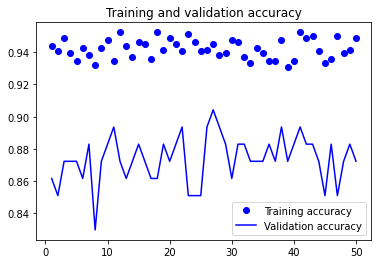

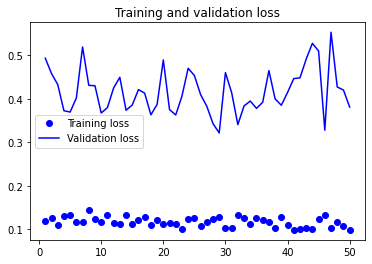

In [ ]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

3/3 [==============================] - 2s 188ms/step - loss: 0.4030 - accuracy: 0.8830
Test accuracy: 0.883
